In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from google.cloud import bigquery
from scipy.stats import skew

from etl.utils.utils_methods import load_params

warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
params = load_params()
PROJECT_ID = params["bigquery"]["project_id"]
DATASET_ID = params["bigquery"]["datasets"]["raw"]
CORE_DATASET_ID = params["bigquery"]["datasets"]["core"]
ANALYTICS_DATASET_ID = params["bigquery"]["datasets"]["analytics"]
print("Working project ID: ", PROJECT_ID)
print("Dataset ID: ", DATASET_ID)
print("Core Dataset ID: ", CORE_DATASET_ID)
print("Analytics Dataset ID: ", ANALYTICS_DATASET_ID)

Working project ID:  olist-data-warehouse-48014
Dataset ID:  olist_dw
Core Dataset ID:  olist_core
Analytics Dataset ID:  olist_analytics


In [3]:
def run_query(query: str, project_id: str) -> pd.DataFrame:
    """
    Run a query to a specified BigQuery project.

    Args:
        query (str): SQL query to run.
        project_id: ID of the BigQuery project to query.

    Returns:
        (pd.DataFrame): pandas DataFrame with the results of the query.
    """
    client = bigquery.Client(project=project_id)
    query_job = client.query(query)
    results = query_job.result()
    return results.to_dataframe()

## Data Overview

In this notebook we'll look into the Brazilian ecommerce dataset by Olist found on <a src="https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce/data">Kaggle</a>: as described by the data card Olist is the largest department store in brazilian marketplaces, it connects small businesses and merchants who are able to sell their products through the Olist store.</br>
The dataset has information of 100k orders from (October) 2016 to 218 from multiple marketplaces.</br>
Throughout our analysis we'll keep monetary data (price, freight cost, revenue etc.) expressed in brazilian Reals since it doesn't affect the analysis.

## Order time trends

Ecommerce is steadily growing worldwide and is predicted to grow further still, let's see if this trend is also found in the Brazilian market: 

### Order count per month

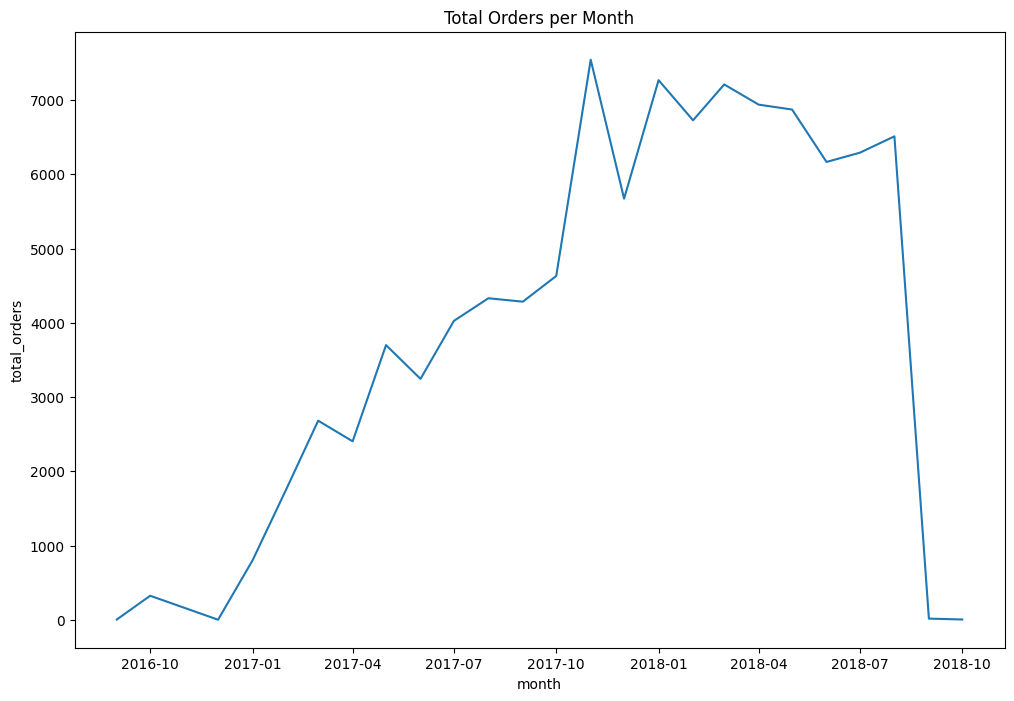

In [18]:
qry = f"""
SELECT DATE_TRUNC(purchase_ts, MONTH) AS month,
COUNT(*) AS total_orders
FROM `{PROJECT_ID}.{DATASET_ID}.orders`
GROUP BY month
ORDER BY month
"""

df = run_query(query=qry, project_id=PROJECT_ID)

plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x="month", y="total_orders")
plt.title("Total Orders per Month")
plt.show()

<ul>
    <li>We can clearly observe a rising trend in total orders.</li>
    <li>In the period between August and October 2018 there's a sharp fall in orders, this is likely to due to noise or incomplete data entry.</li>
</ul>

We also observe a peak on November 2017:

In [21]:
df[df["total_orders"] == df["total_orders"].max()]

,month,total_orders
13,2017-11-01 00:00:00+00:00,7544


This is likely due to Black Friday, which in 2017 was on November 24th.

## Total orders by week day

/tmp/ipykernel_8813/2136423417.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="weekday_name", y="total_orders", palette="mako")


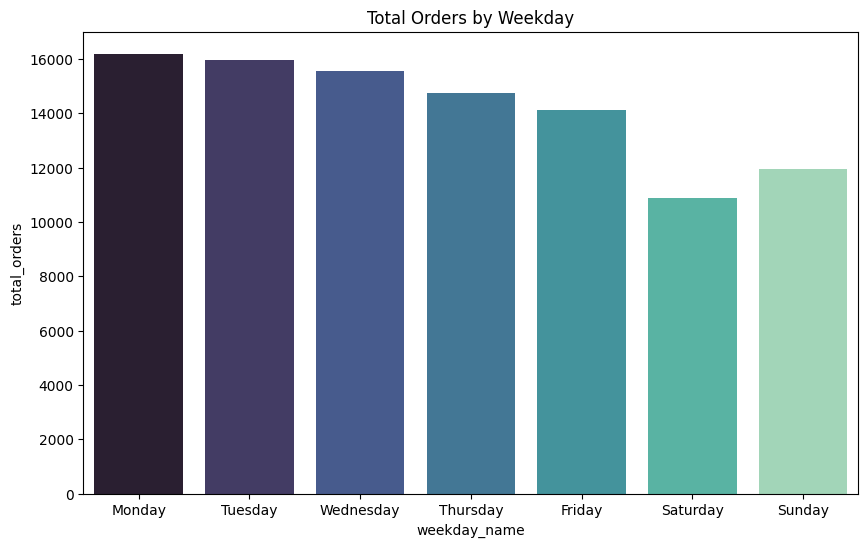

In [32]:
qry = f"""
SELECT
MOD(EXTRACT(DAYOFWEEK FROM purchase_ts) + 5, 7)  AS weekday_number,
FORMAT_TIMESTAMP('%A', purchase_ts) AS weekday_name,
COUNT(*) AS total_orders
FROM `{PROJECT_ID}.{DATASET_ID}.orders`
GROUP BY weekday_number, weekday_name
ORDER BY weekday_number
"""

df = run_query(query=qry, project_id=PROJECT_ID)
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="weekday_name", y="total_orders", palette="mako")
plt.title("Total Orders by Weekday")
plt.show()

The total orders peaks on Monday, generally decreasing throughout the week with a minimum on Saturday. 

## Geo Analysis

Brazil is divided in 26 state (and one federal district), each of them endowed with a certain degree of autonomy, therefore we're interested in analizing the ecommerce volume among the different states to check for regional differences, we start looking at total orders and revenue:

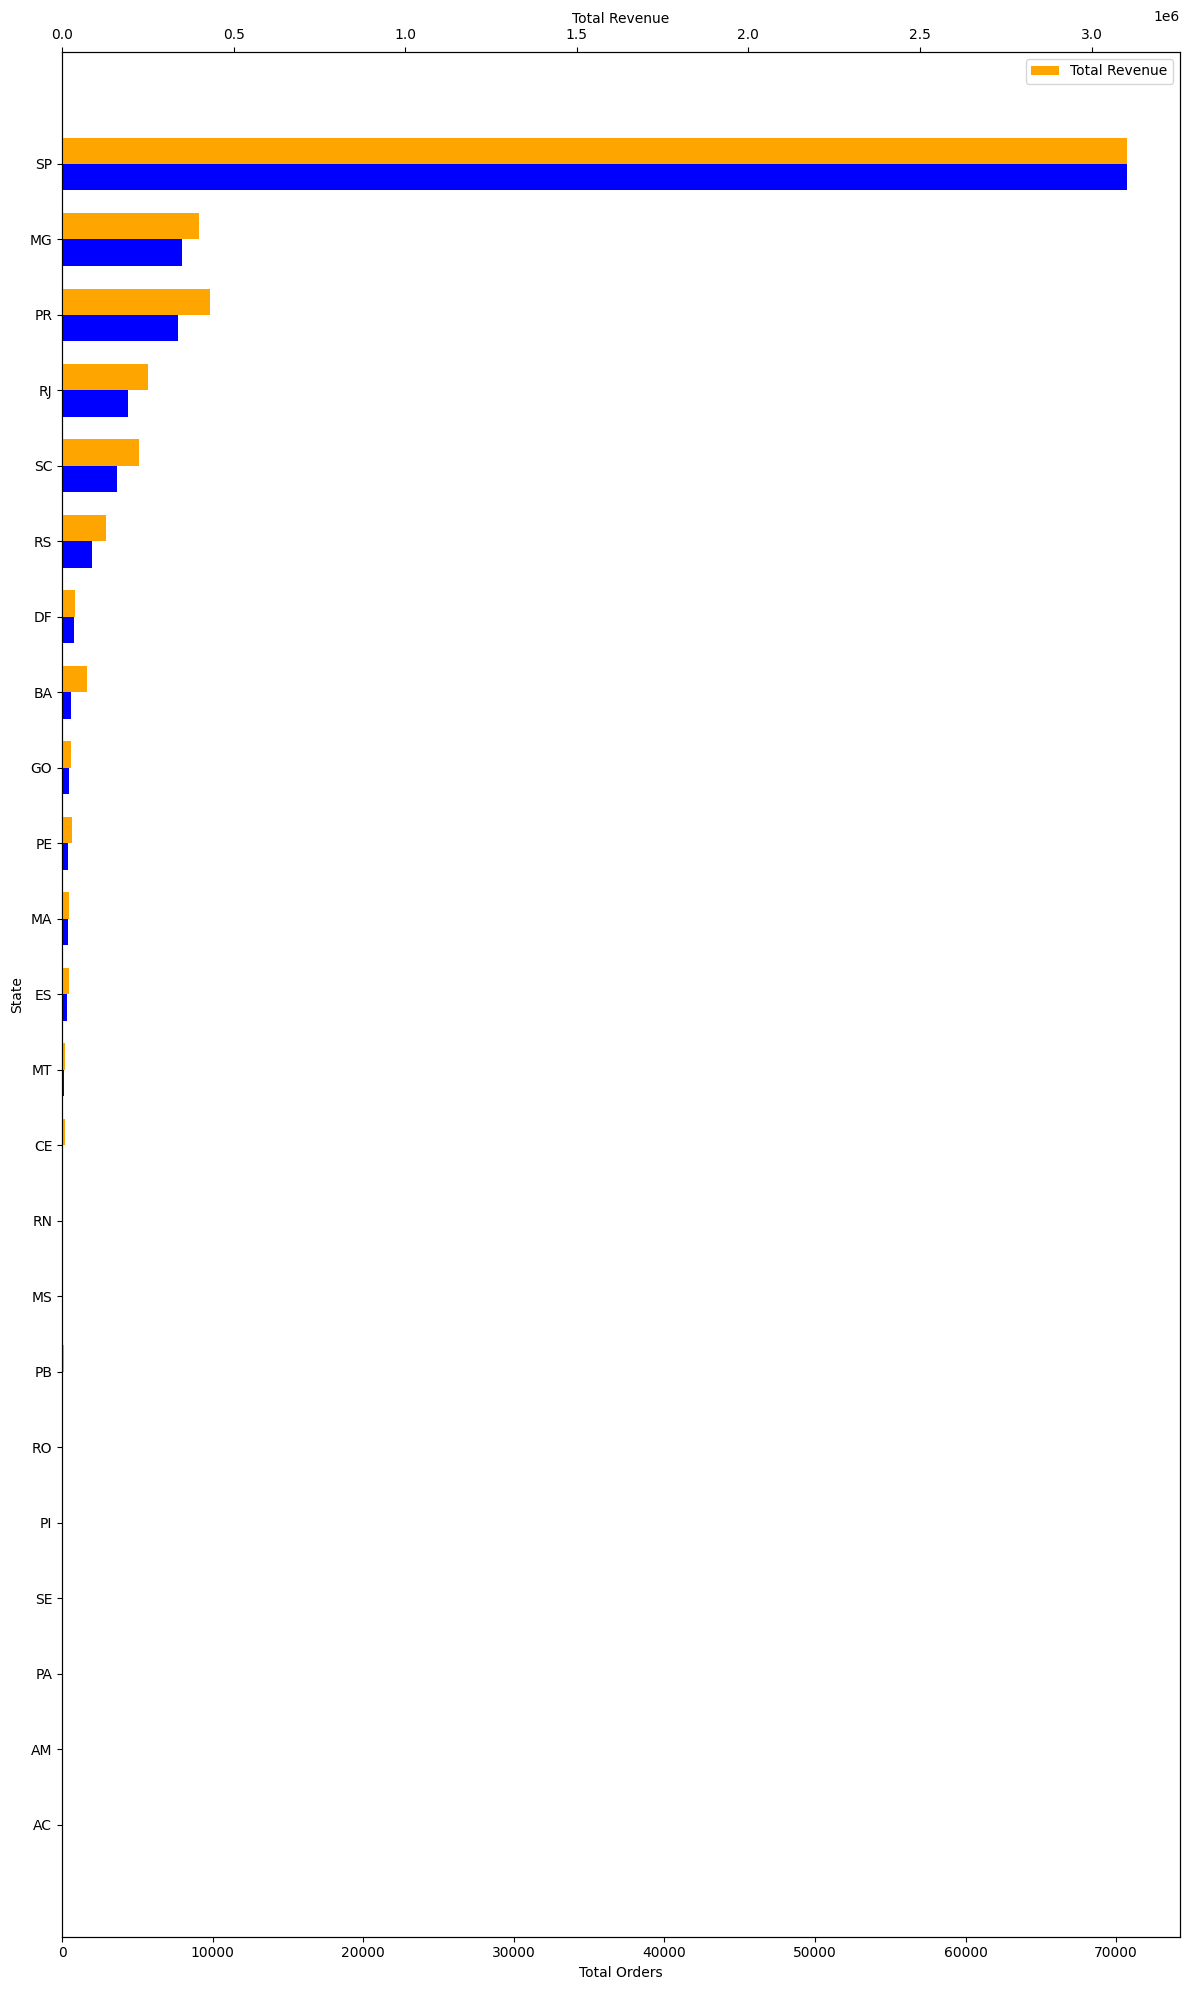

In [5]:
qry = f"""
SELECT 
    *
FROM `{PROJECT_ID}.{ANALYTICS_DATASET_ID}.orders_revenue_by_location`
"""

df_geo = run_query(query=qry, project_id=PROJECT_ID)

df_state_ord = (
    df_geo.groupby(by=["state"]).sum().sort_values(by="total_orders", ascending=True)
)
x_idx = np.arange(len(df_state_ord))
bar_width = 0.35
_, ax1 = plt.subplots(1, 1, figsize=(12, 20))
ax1.barh(
    x_idx,
    df_state_ord["total_orders"],
    height=bar_width,
    color="blue",
    label="Total Orders",
)
ax2 = ax1.twiny()
ax2.barh(
    x_idx + bar_width,
    df_state_ord["total_revenue"],
    height=bar_width,
    label="Total Revenue",
    color="orange",
)
ax1.set_ylabel("State")
ax1.set_xlabel("Total Orders")
ax2.set_xlabel("Total Revenue")
ax1.set_yticks(x_idx + bar_width / 2)
ax1.set_yticklabels(df_state_ord.index)
plt.legend()
plt.tight_layout()
plt.show()

Looking at the top three states, while Minas Gerais (MG) and Paranà (PR) have similar statistics, São Paulo (SP) drastically dominates the total orders and revenue contributions; to get a better insight we increase the level of granularity to the city level:

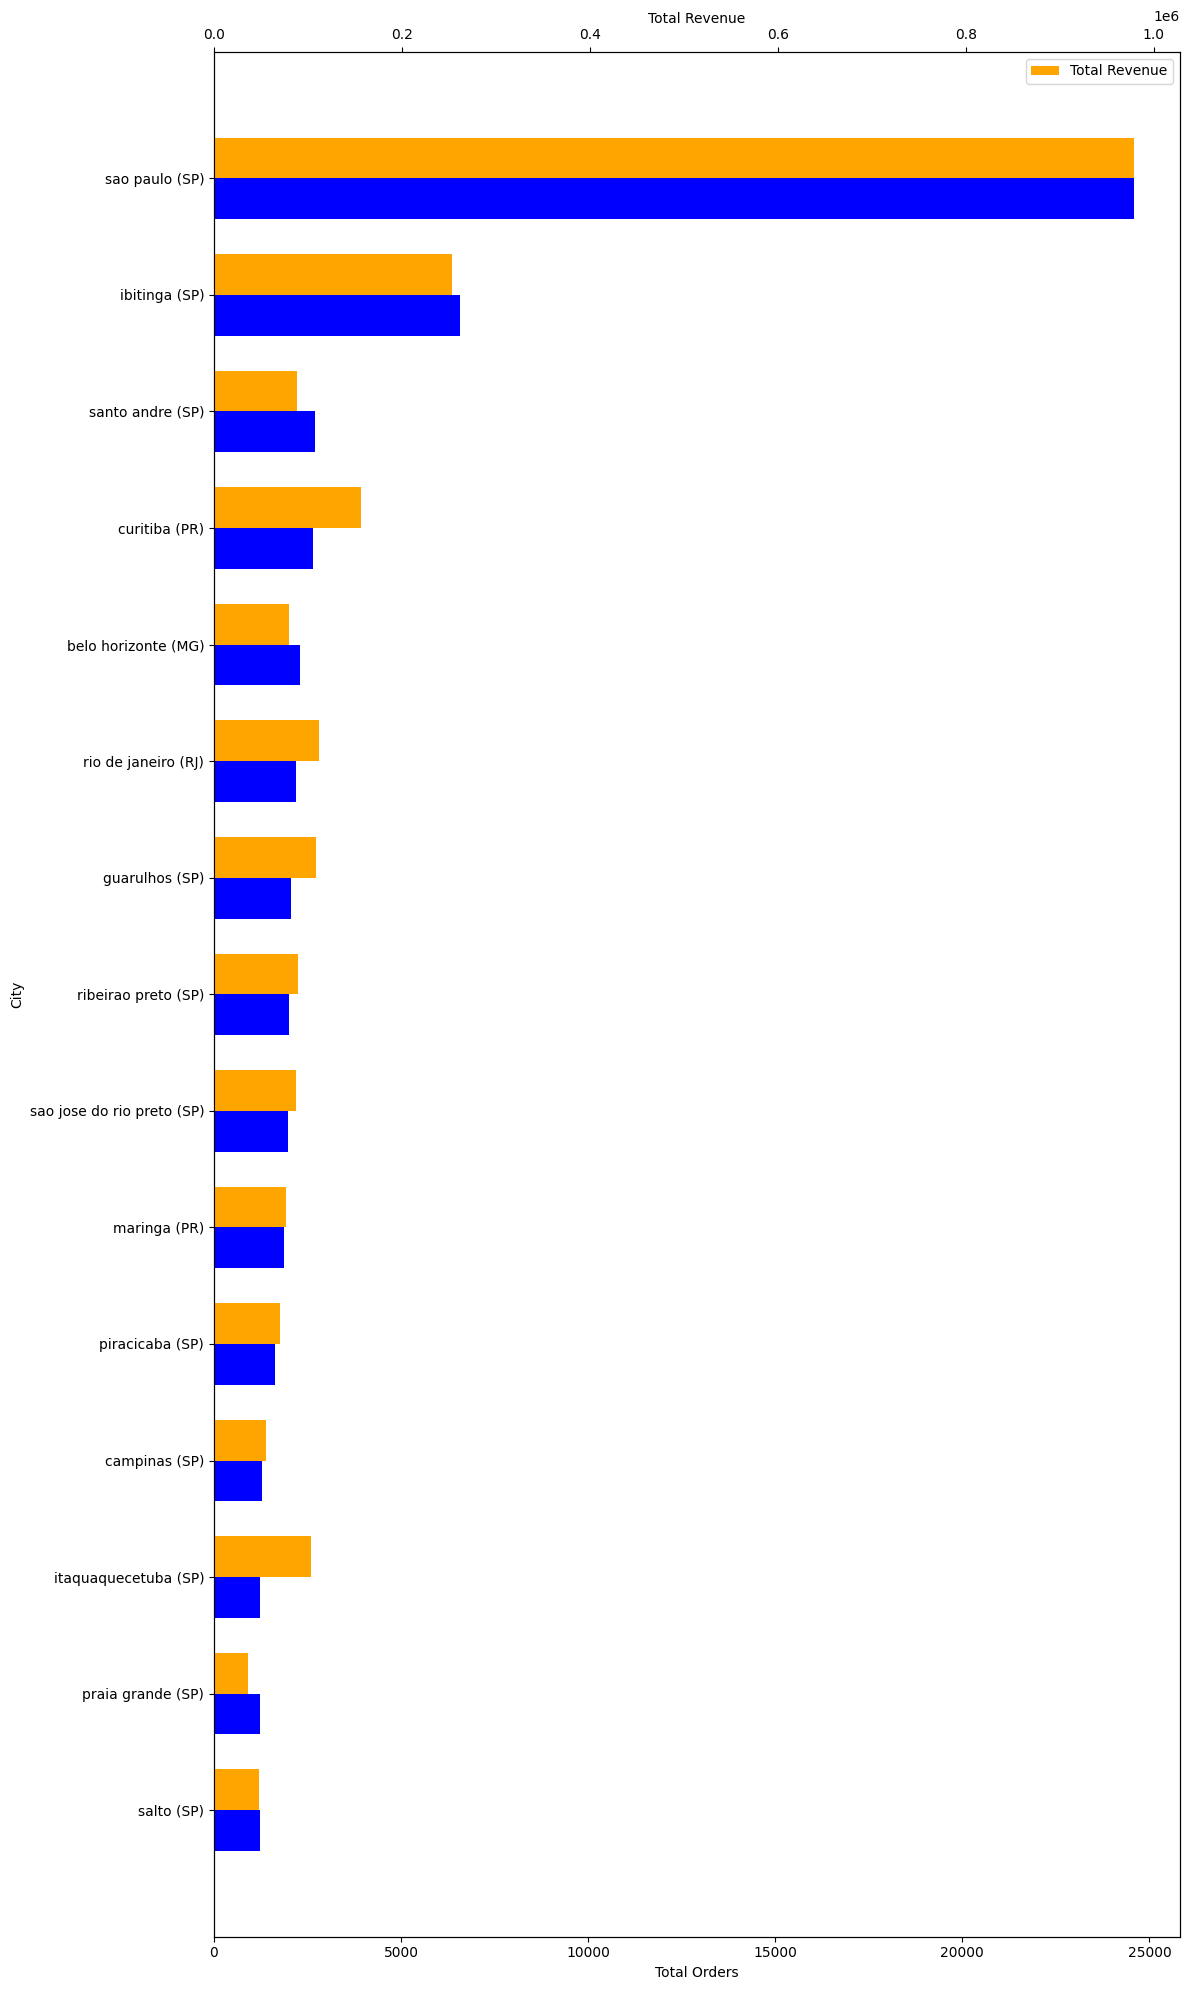

In [46]:
df_city_ord = (
    df_geo.groupby(by=["city", "state"])
    .sum()
    .sort_values(by="total_orders", ascending=True)
    .iloc[-15:, :]
    .reset_index()
)

x_idx = np.arange(len(df_city_ord))
bar_width = 0.35
_, ax1 = plt.subplots(1, 1, figsize=(12, 20))
ax1.barh(
    x_idx,
    df_city_ord["total_orders"],
    height=bar_width,
    color="blue",
    label="Total Orders",
)
ax2 = ax1.twiny()
ax2.barh(
    x_idx + bar_width,
    df_city_ord["total_revenue"],
    height=bar_width,
    label="Total Revenue",
    color="orange",
)
ax1.set_ylabel("City")
ax1.set_xlabel("Total Orders")
ax2.set_xlabel("Total Revenue")
ax1.set_yticks(x_idx + bar_width / 2)
ax1.set_yticklabels(df_city_ord["city"] + " (" + df_city_ord["state"] + ")")
plt.legend()
plt.tight_layout()
plt.show()

The situation is now clear: 11 of the 15 top cities per total orders belong to the São Paulo state, among them the city of São Paulo is clearly the major driver of both orders and revenue, which is not surprising given that it's the most populous city in Brazil.</br>
However Rio de Janeiro is the second most populous and while the state of Rio is among the top 6 the disparity in revenue between state/cities is surprising: let's make a quick check about the number of seller in each city

In [16]:
qry = f"""
SELECT
seller_id, city, state
FROM `{PROJECT_ID}.{DATASET_ID}.sellers`
WHERE city IN {"sao paulo", "rio de janeiro"}
"""
df = run_query(query=qry, project_id=PROJECT_ID)
df["city"].value_counts()

city
sao paulo         694
rio de janeiro     96
Name: count, dtype: int64

Rio de Janeiro has less than a seventh of sellers than São Paulo has, there could be reasonable motivations behind this difference or a natural direction to expand business.

### Average price and Total revenue by state

A next step in the analysis of revenue stratified by state consists of studying it in relation to another feature (i.e. a bivariate analysis); in this instance we take a look at both the total revenue and the average price for each state:

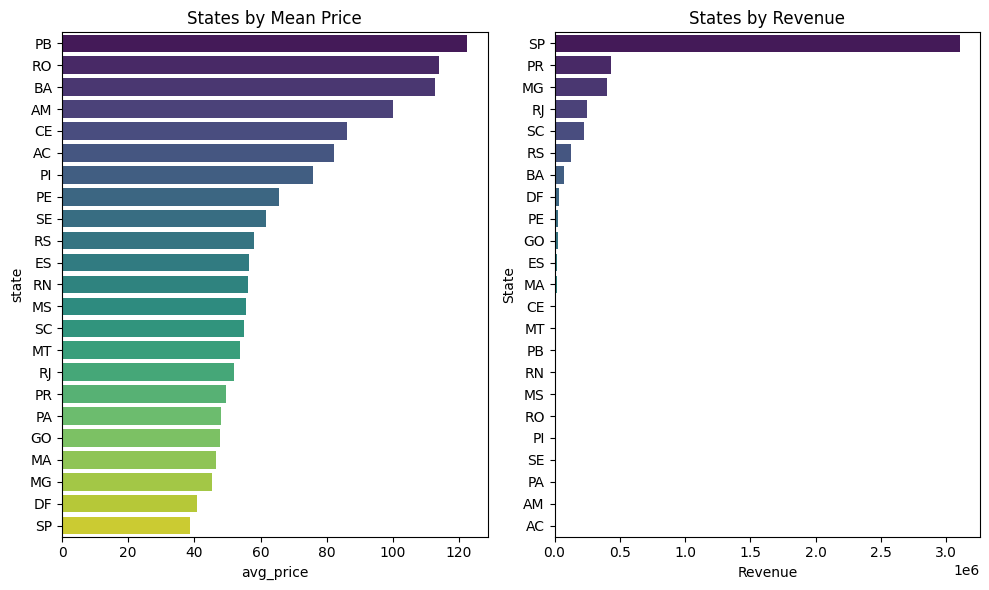

In [6]:
df_price_revenue = df_geo.groupby(by=["state"]).sum().reset_index()
df_price_revenue["avg_price"] = (
    df_price_revenue["total_revenue"] / df_price_revenue["n_items"]
)

_, axes = plt.subplots(1, 2, figsize=(10, 6))
for cname, label, ax in zip(
    ["avg_price", "total_revenue"], ["Mean Price", "Revenue"], axes.ravel()
):
    sns.barplot(
        data=df_price_revenue.sort_values(by=cname, ascending=False),
        x=cname,
        y="state",
        ax=ax,
        palette="viridis",
    )
    ax.set_title(f"States by {label}")
    plt.xlabel(label)
    plt.ylabel("State")
plt.tight_layout()
plt.show()

Interestingly there's a mild, but significant inverse relationship between average price and total revenue. 

In [13]:
print(
    "Correlation score between mean price and total revenue by state: ",
    df_price_revenue.select_dtypes(include=float)
    .corr(method="spearman")
    .loc["total_revenue", "avg_price"],
)

Correlation score between mean price and total revenue by state:  -0.5158102766798419


## Product analysis

We proceed by looking which product categories are the most (and least) sought-after, both in terms of total orders and revenue.

### Top/Bottom 15 products categories

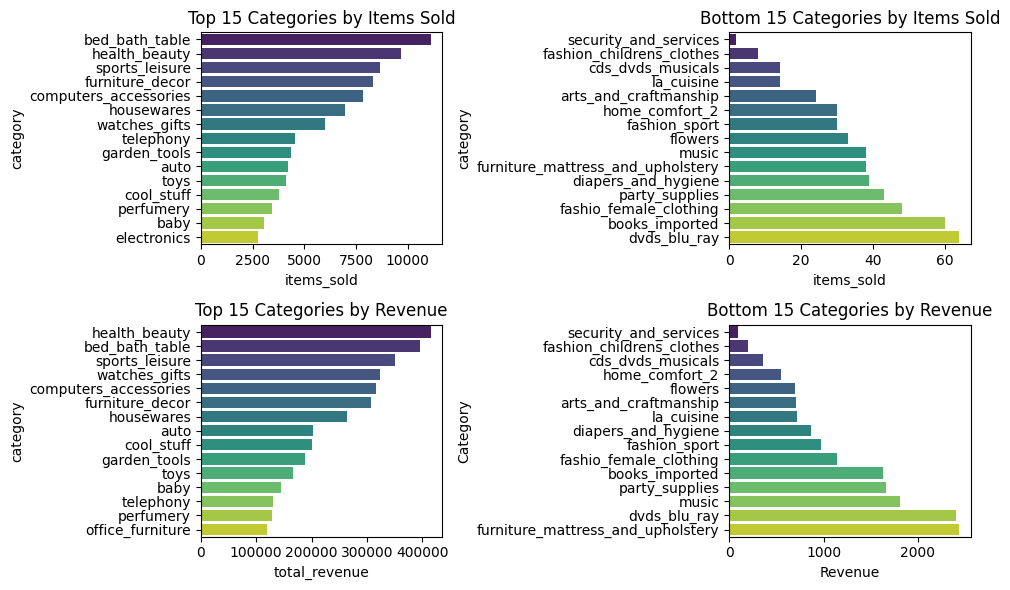

In [10]:
qry = f"""
SELECT 
    dp.category,
    COUNT(oi.order_id) AS items_sold,
    SUM(oi.total_item_value) AS total_revenue
FROM `{PROJECT_ID}.{CORE_DATASET_ID}.fact_order_items` oi
JOIN `{PROJECT_ID}.{CORE_DATASET_ID}.dim_products` dp ON oi.product_id = dp.product_id
GROUP BY dp.category
"""

df_category = run_query(query=qry, project_id=PROJECT_ID)

_, axes = plt.subplots(2, 2, figsize=(10, 6))
for cname, label, is_ascending, ax in zip(
    ["items_sold", "items_sold", "total_revenue", "total_revenue"],
    ["Items Sold", "Items Sold", "Revenue", "Revenue"],
    [False, True, False, True],
    axes.ravel(),
):
    sns.barplot(
        data=df_category.sort_values(by=cname, ascending=is_ascending).iloc[:15, :],
        x=cname,
        y="category",
        ax=ax,
        palette="viridis",
    )
    top_bottom = "Bottom" if is_ascending else "Top"
    ax.set_title(f"{top_bottom} 15 Categories by {label}")
    plt.xlabel(label)
    plt.ylabel("Category")
plt.tight_layout()
plt.show()

Sport leisure, bed bath table and health beauty products are the ones most ordered and that generate most revenue, while security & services, fashion children clothes and cd/dvds are poor performing.

## Reviews Analysis

### Review score distribution

We'll focus our attention to reviews, the data card doen't give a clear indication on how the score scale should be interpreted, but comparing reviews score to their comments it's clear that it's a 1-to-5 stars sysyem (1 stands for lowest satisfaction, 5 for highest), we start by simply looking at the score distribution:

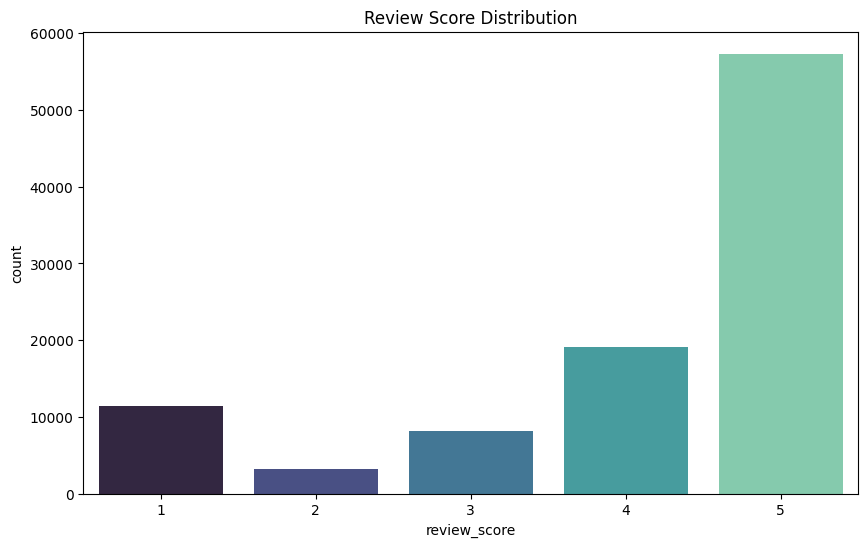

In [5]:
qry = f"""
SELECT score AS review_score,
COUNT(*) AS count
FROM `{PROJECT_ID}.{DATASET_ID}.reviews`
GROUP BY score
ORDER BY score DESC
"""

df = run_query(query=qry, project_id=PROJECT_ID)

plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="review_score", y="count", palette="mako")
plt.title("Review Score Distribution")
plt.show()

In [6]:
100 * df["count"] / df["count"].sum()

0    57.776344
1    19.291704
2     8.242965
3     3.175643
4    11.513344
Name: count, dtype: Float64

Roughly 58% of the reviews have the highest score, and 76% of reviewed orders earned 4 of 5 stars, that's an impressive result, but it still raise the question:</br><i>What affects the review scores positively or negatively?</i></br>To answer this question we retrive a dataframe that has data for every order such as:</br>
<ul>
    <li>delivery time</li>
    <li>delay</li>
    <li>price</li>
    <li>freight value</li>
</ul>
we supect have an impact on ratings.

In [7]:
"""FACT_ORDERS_ENRICHED
SELECT 
o.order_id,
o.product,
c.state AS state,
o.order_status AS status,
o.delivery_time,
o.delay,
o.price, 
o.freight_value,
o.basket_size,
o.n_products,
r.score AS score
FROM `{{ PROJECT_ID }}.{{ CORE_DATASET_ID }}.fact_orders` o
JOIN `{{ PROJECT_ID }}.{{ RAW_DATASET_ID }}.customers` c ON o.customer_id = c.customer_id
JOIN `{{ PROJECT_ID }}.{{ CORE_DATASET_ID }}.reviews_agg` r ON o.order_id = r.order_id
WHERE r.score IS NOT NULL;
"""

qry = f"""
SELECT * 
FROM `{PROJECT_ID}.{ANALYTICS_DATASET_ID}.fact_orders_enriched`
"""

order_rating = run_query(query=qry, project_id=PROJECT_ID)
order_rating.head()

,order_id,product,state,status,delivery_time,delay,price,freight_value,basket_size,n_products,score
0,bfbd0f9bdef84302105ad712db648a6c,5a6b04657a4c5ee34285d1e4619a96b4,SP,delivered,54,36,24.981192,8.49,3,1,1
1,98974b076b01553d49ee6467905675a7,ecf23a6c1689e2bed38171ececac6138,SP,delivered,43,-6,20.341061,11.23,1,1,1
2,c4b41c36dd589e901f6879f25a74ec1d,9e93b2c4cb5eea05e75a481c129b104d,SP,delivered,36,-14,1.832361,8.72,1,1,5
3,d2292ff2201e74c5db154d1b7ae68cbb,e1ed3c28e40cbce2783e79eea79e8701,SP,delivered,29,-20,9.235841,11.74,1,1,5
4,95e01270fcbae9863423400103359279,b73f6899a58fe7a37e55149e9a11c717,SP,delivered,30,-19,16.100718,28.23,1,1,2


Let's see some summary statistics for the numerical features:

In [8]:
order_rating.describe()

,delivery_time,delay,price,freight_value,basket_size,n_products,score
count,95824.0,95824.0,97917.000000,97917.000000,97917.0,97917.0,98673.0
mean,12.052273,-10.993018,25.455809,22.804014,1.140844,1.037899,4.086062
std,9.466046,9.950629,38.772509,21.621022,0.533783,0.225801,1.347714
min,0.0,-146.0,0.157324,0.000000,1.0,1.0,1.0
25%,6.0,-16.0,8.495493,13.840000,1.0,1.0,4.0
50%,10.0,-11.0,16.084060,17.160000,1.0,1.0,5.0
75%,15.0,-6.0,27.744541,24.010000,1.0,1.0,5.0
max,208.0,188.0,2487.569280,1794.960000,21.0,8.0,5.0


**Outtakes:**
<ul>
    <li>Delay is mostly negative (more than 75% of orders arrived earlier than expected), however there is at least of case of extreme delay (one order was delivered 6 months late!).</li>
    <li>Price and freight value have comparables mean and stadard deviation, however these features are bounded from below by 0, we therefore suspect and heavier right tail in their distribution.</li>
    <li>The mean and the three inter-quartiles of both basket_size and n-products is 1, suggesting that most orders were single-product (i.e. include only one product type) and single-item (i.e. include only one istance of that product).</li>
</ul>

## Univariate Analysis

We first study the features distributions to check for their shapes and eventally the necessity of data transformation:

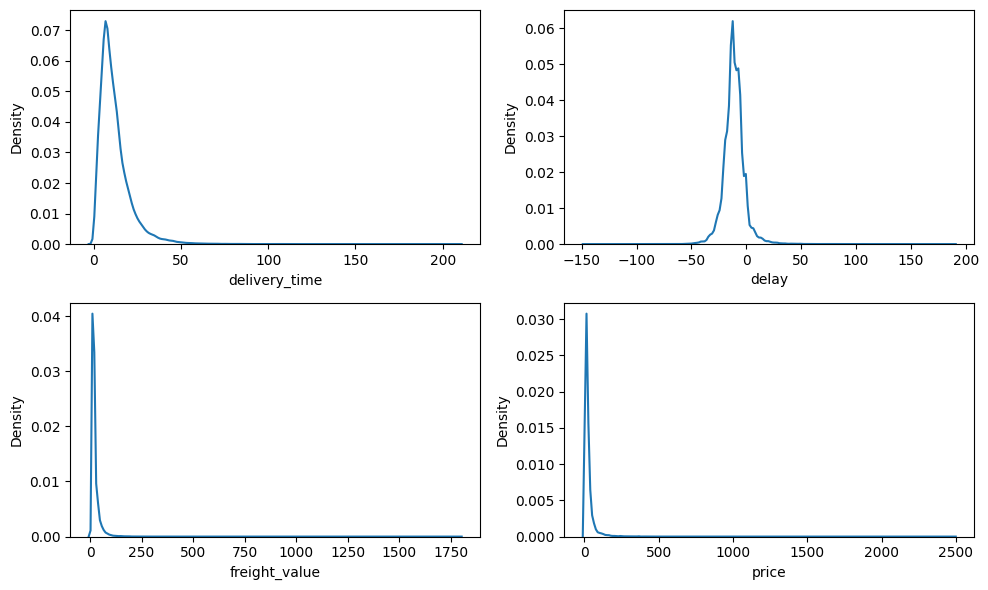

In [23]:
_, axes = plt.subplots(2, 2, figsize=(10, 6))
for ax, col in zip(axes.ravel(), ["delivery_time", "delay", "freight_value", "price"]):
    sns.kdeplot(data=order_rating, x=col, ax=ax)
plt.tight_layout()
plt.show()

In [13]:
for col in ["delivery_time", "delay", "freight_value", "price"]:
    print(f"{col} skewness: {skew(order_rating[col], nan_policy='omit')}")

delivery_time skewness: 3.7661870210394484
delay skewness: 1.9061751211214961
freight_value skewness: 12.11600010799198
price skewness: 9.607110875345345


While delay has a roughly symmetrical distribution, delivery time, freight value and price all have a heavy right tail, this is a common pattern in real business data and it's not automatically indicative of outliers.</br>
For exploratory and descriptive analysis, all variables are analyzed in their original units for interpretability, while for multivariate regression models, log-transformed versions are introduced to reduce the influence of extreme values and to better satisfy linearity and variance assumptions.

### Bivariate Analysis

The next step to understand a feature effect on the review score is to analyze its distribution for each score value:

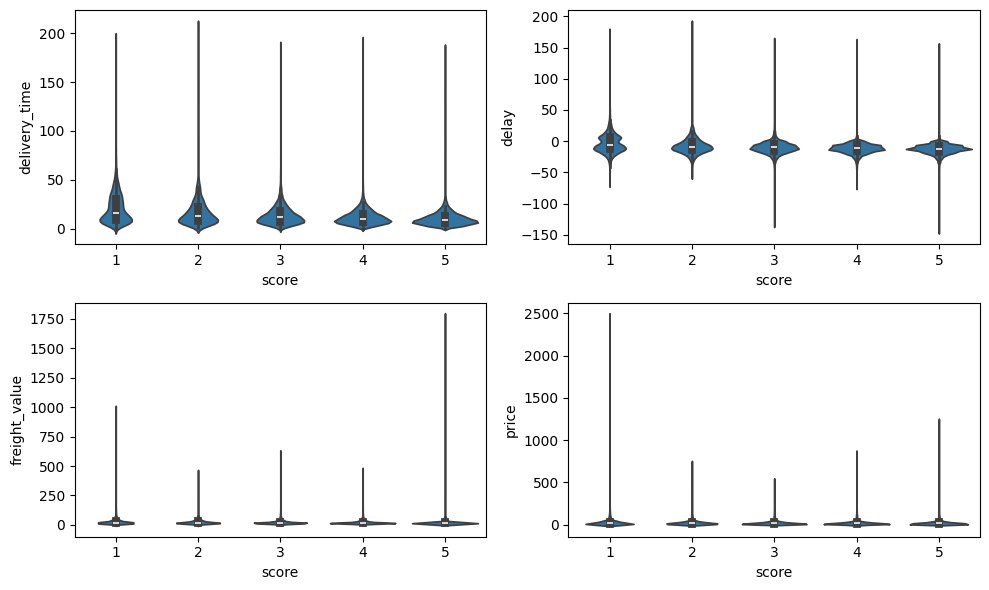

In [19]:
_, axes = plt.subplots(2, 2, figsize=(10, 6))
for ax, col in zip(axes.ravel(), ["delivery_time", "delay", "freight_value", "price"]):
    sns.violinplot(data=order_rating, x="score", y=col, ax=ax)
plt.tight_layout()
plt.show()

The heavy tails make it difficult to discern the main distribution, but we can still infer interesting information: low score orders experience a majority of positive delays (i.e. orders arriving late) while high score orders were often delivered early; this aligns well with customer expecations (late deliveries lead to dissatisfaction while early or on-time deliveries lead to higher ratings).</br>
Among 1-star orders we find the most expensive ones, this could be something to investigate, because we could have not satisfied important customers.</br>
To see better the main distribution we produce boxplot without fliers:

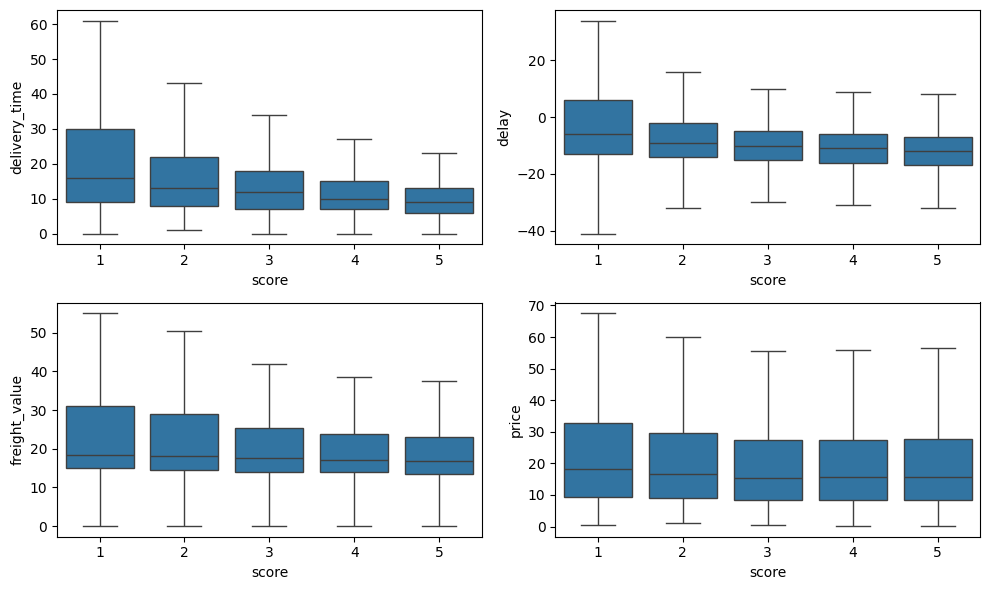

In [14]:
_, axes = plt.subplots(2, 2, figsize=(10, 6))
for ax, col in zip(axes.ravel(), ["delivery_time", "delay", "freight_value", "price"]):
    sns.boxplot(data=order_rating, x="score", y=col, showfliers=False, ax=ax)
plt.tight_layout()
plt.show()

For both delivery time and delay the main distribution becomes narrower and with smaller medians as the review score increases, this suggests that as the customer give higher ratings both delivery time and delay becomes more consistent and shorter, freight value and price have a similar but less pronunciated pattern.</br>
To make even more apparent if the central tendency changes with score we make pointplots for both the mean and median of each features across the review score values:

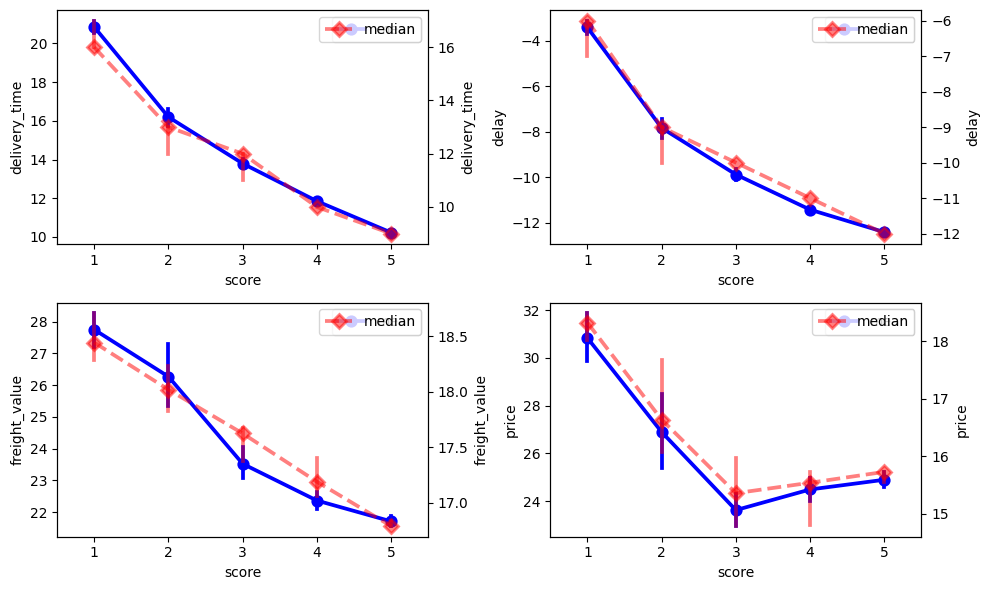

In [9]:
_, axes = plt.subplots(2, 2, figsize=(10, 6))
for ax, col in zip(axes.ravel(), ["delivery_time", "delay", "freight_value", "price"]):
    sns.pointplot(
        data=order_rating,
        x="score",
        y=col,
        estimator="mean",
        errorbar=("ci", 95),
        color="blue",
        label="mean",
        ax=ax,
    )
    ax2 = ax.twinx()
    sns.pointplot(
        data=order_rating,
        x="score",
        y=col,
        estimator="median",
        errorbar=("ci", 95),
        color=(1.0, 0.0, 0.0, 0.5),
        linestyle="--",
        marker="D",
        label="median",
        ax=ax2,
    )
plt.tight_layout()
plt.show()

The means and he medians for both delivery time and delay distribution are close together and follows the same descending trend, indicating a significant effect size, the behaviour of freight values and price central tendencies is more erratic, suggesting their influence as confounding measures.

### Reviews multiple regression

One common way to explore the conditional average effects is to actually fit a regression model, in order to do so we first perform two preparatory steps; the first one is to log-transform features with high skewness since:
<ul>
    <li>OLS models work best when the residuals assumption is satisfied, i.e. when the residuals are normally distributed,  reducing the skewness and making the data more symmetrical helps.</li>
    <li>Linear models assume a linear relationship between the dependent and the independent variables, an heavy tail in a distribution can suggest a non-linear relationship and a log-transformation can reduce non-linearity.</li>
    <li>A skewed feature often has heteroscedastic (non constant variance), while linear regression assumes the variance of the residual constant (homoscedasticity).</li>
</ul>

In [17]:
for cname in ["delivery_time", "price", "freight_value"]:
    order_rating["log_" + cname] = np.log1p(order_rating[cname])

order_rating.head()

,order_id,product,state,status,delivery_time,delay,price,freight_value,basket_size,n_products,score,log_delivery_time,log_price,log_freight_value
0,bfbd0f9bdef84302105ad712db648a6c,5a6b04657a4c5ee34285d1e4619a96b4,SP,delivered,54,36,24.981192,8.49,3,1,1,4.007333,3.257373,2.250239
1,98974b076b01553d49ee6467905675a7,ecf23a6c1689e2bed38171ececac6138,SP,delivered,43,-6,20.341061,11.23,1,1,1,3.78419,3.060633,2.503892
2,c4b41c36dd589e901f6879f25a74ec1d,9e93b2c4cb5eea05e75a481c129b104d,SP,delivered,36,-14,1.832361,8.72,1,1,5,3.610918,1.041111,2.274186
3,d2292ff2201e74c5db154d1b7ae68cbb,e1ed3c28e40cbce2783e79eea79e8701,SP,delivered,29,-20,9.235841,11.74,1,1,5,3.401197,2.325895,2.544747
4,95e01270fcbae9863423400103359279,b73f6899a58fe7a37e55149e9a11c717,SP,delivered,30,-19,16.100718,28.23,1,1,2,3.433987,2.839120,3.375196


Second, since reviews in the Olist dataset are associated with orders rather than individual products, we restrict the analysis to orders containing a single distinct product. This includes both single-item orders and orders with multiple units of the same product, under the assumption that the review reflects the customer’s experience with that product.</br> Orders containing multiple distinct products are excluded to avoid ambiguity in review attribution.</br>
We then fit the model and display its summary:

In [18]:
order_rating_1p = order_rating[order_rating["n_products"] == 1].dropna()
model = smf.ols(
    "score ~ delay + log_delivery_time + log_price + log_freight_value + C(state)",
    data=order_rating_1p,
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     432.3
Date:                Thu, 25 Dec 2025   Prob (F-statistic):               0.00
Time:                        10:46:58   Log-Likelihood:            -1.4770e+05
No. Observations:               93155   AIC:                         2.955e+05
Df Residuals:                   93124   BIC:                         2.958e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.2960      0.13

**Outtakes:**
<ul>
    <li>From the R-squared we see that the model explains ~12.2% of the variance in review scores, which is not much, but still considerable for review score regression.</li>
    <li>F-statistic at 0.00 suggests that the model is statistically meaningful.</li>
    <li>The delay coefficient at -0.0247 is the strongest signal signal in the model and indicates a negative correlation with review score (every 10 days the score lower by ~0.25 points).</li>
    <li>The log_delivery_time coefficient at -0.4437 means that for a 1% increase in delivery time changes the score by -0.4437*0.01=-0.004437.</li>
    <li>The log_freight_value coefficient at -0.0979 means that for a 1% increase in freight value changes the score by -0.0979*0.01~-0.001</li>
    <li>Regarding log_price, the p-value at 0.118 suggests that the price doesn't strongly affect reviews, and customers are more sensitive to logistic.</li>
    <li>The high conditional number suggests possible multicollinearity; a possible reason is that longer delivery time leads to an higher chance of delay and higher freight cost. </li>
</ul>

### Reviews by Products

Up until now our review scores analysis took into account only logistics (delivery time and delay) and economics (price and freight cost), while disregarding an important contribution: the quality of the product itself and the consequent satisfaction provided.</br>
The estimate of this contribution is the topic of this section; the analysis strategy we choose to adopt must consider the high cardinality of the product feature, which has almost 33k unique values, this lead us to follow two approaches: </br>
<ul>
    <li>Making a rating estimate based on product categories (and not all the products themselves), since they're fewer.</li>
    <li>Performing a mixed effects model regression, in this way the products rating effects is estimated by BLUPs (Best Linear Unbiased Predictors).</li>
</ul>

### Reviews - Categories effects

We first retrieve the necessary data; we once again consider orders of a single product (but possibly multiple items) and build a dataframe with one row for each product reviewed together with its category, number of reviews and aggregated data:

In [9]:
"""FACT_PRODUCTS_ENRICHED
WITH single_item_orders AS (
    SELECT 
        o.order_id,
        o.n_products
    FROM `{{ PROJECT_ID }}.{{ CORE_DATASET_ID }}.fact_orders` o
    WHERE o.n_products = 1
),
oi_enriched AS (
    SELECT 
        oi.order_id,
        oi.product_id,
        oi.price,
        oi.freight_value
    FROM `{{ PROJECT_ID }}.{{ CORE_DATASET_ID }}.fact_order_items` oi
    JOIN single_item_orders sio ON oi.order_id = sio.order_id
)
SELECT
    oi.product_id,
    p.category,
    
    -- Review
    COUNT(r.score) AS n_reviews,
    AVG(r.score) AS avg_score,
    
    -- Logistic
    AVG(o.delivery_time) AS avg_delivery_time,
    AVG(o.delay) AS avg_delay,
    AVG(CASE WHEN o.delay > 0 THEN 1 ELSE 0 END) AS pct_delayed,

    --Economics
    AVG(oi.price) AS avg_price,
    AVG(oi.freight_value) AS avg_freight_value

FROM oi_enriched oi
JOIN `{{ PROJECT_ID }}.{{ CORE_DATASET_ID }}.fact_orders` o ON oi.order_id = o.order_id
JOIN `{{ PROJECT_ID }}.{{ CORE_DATASET_ID }}.reviews_agg` r ON oi.order_id = r.order_id
LEFT JOIN `{{ PROJECT_ID }}.{{ CORE_DATASET_ID }}.dim_products` p ON oi.product_id = p.product_id
GROUP by oi.product_id, p.category; 
"""

qry = f"""
SELECT 
    *
FROM `{PROJECT_ID}.{ANALYTICS_DATASET_ID}.fact_products_enriched` 
"""

product_rating = run_query(query=qry, project_id=PROJECT_ID)
product_rating.head()

,product_id,category,n_reviews,avg_score,avg_delivery_time,avg_delay,pct_delayed,avg_price,avg_freight_value
0,47d52bb24ef8a3aa09724f00604be3ba,dvds_blu_ray,2,3.0,6.0,-11.0,0.0,262.823540,16.905000
1,361009da0572b0d1d961d347f10e09b1,furniture_living_room,2,2.0,NaN,NaN,0.0,25.727093,24.715000
2,c9da1aa6e29221a1aabf1131aa2134e8,fixed_telephony,1,1.0,NaN,NaN,0.0,47.919024,15.980000
3,fbecfbe44e34c5291e5499870cd5db2e,market_place,1,1.0,NaN,NaN,0.0,16.657830,50.000000
4,50692766f5927d896a4b516389e92b4a,costruction_tools_garden,3,4.0,6.5,-15.0,0.0,26.140454,29.533333


However, the average review scores of different products don't have the same level of confidence, since they have different number of reviews.</br> 
We therefore apply Bayes shrinkage to the average rating scores: this adjust each score to the global mean based on their uncertainty, essentially we expect score with few reviews to suffers from a lot of noise (i.e. lot of variance) and we try to make the best estimate for the true rating (trading bias for variance).</br>
To do so we must first define a parameter k (conceptually equivalent the number of reviews needed to trust a score), which we can estimate: 

In [14]:
# within-product variance
sigma2_within = order_rating["score"].var()
# overall average reviews mean
mu = np.average(product_rating["avg_score"], weights=product_rating["n_reviews"])
# observed variance of product means
observed_var = np.average(
    (product_rating["avg_score"] - mu) ** 2, weights=product_rating["n_reviews"]
)
# noise variance
noise_var = np.average(
    sigma2_within / product_rating["n_reviews"], weights=product_rating["n_reviews"]
)
# between-product variance
sigma2_between = max(observed_var - noise_var, 1e-6)
k = sigma2_within / sigma2_between
print("sigma2_within: ", sigma2_within)
print("sigma2_between: ", sigma2_between)
print("k: ", k)

sigma2_within:  1.7734131468826466
sigma2_between:  0.19420180094871609
k:  9.131805875224408


We can now compute the shrunk scores:

In [15]:
def apply_mean_shrinkage(df, score_col="avg_score", count_col="n_reviews", k=20):
    global_mean = np.average(df[score_col], weights=df[count_col])

    shrunk = (df[count_col] * df[score_col] + k * global_mean) / (df[count_col] + k)

    return shrunk


product_rating["shrunk_score"] = apply_mean_shrinkage(df=product_rating, k=9)
product_rating.head()

,product_id,category,n_reviews,avg_score,avg_delivery_time,avg_delay,pct_delayed,avg_price,avg_freight_value,shrunk_score
0,98224bfc1eaadb3a394ec334c60453ff,auto,12,4.833333,8.250000,-10.416667,0.0,0.786620,11.906667,4.513489
1,5dbf50af9485478b933f1028e108640d,electronics,11,4.090909,10.909091,-16.909091,0.0,1.075019,17.090000,4.089164
2,d7b39598905ba8e791fe3f1f376d59f9,None,7,1.571429,6.142857,-23.571429,0.0,0.884716,14.692857,2.986454
3,72b253635b316f49e42e618d6e585ebc,toys,8,4.125000,6.375000,-10.000000,0.0,2.431580,14.781250,4.104898
4,cdafffbe81c76e4cb8b1270523215c82,perfumery,8,3.500000,7.500000,-8.750000,0.0,0.923584,12.670000,3.810781


Now we can calculate the average score by product category; this is again a weighted average, where now the number of reviws are not an expression on uncertainty, but rather just frequency: we are basically stating that popular products matter more than product with few reviews

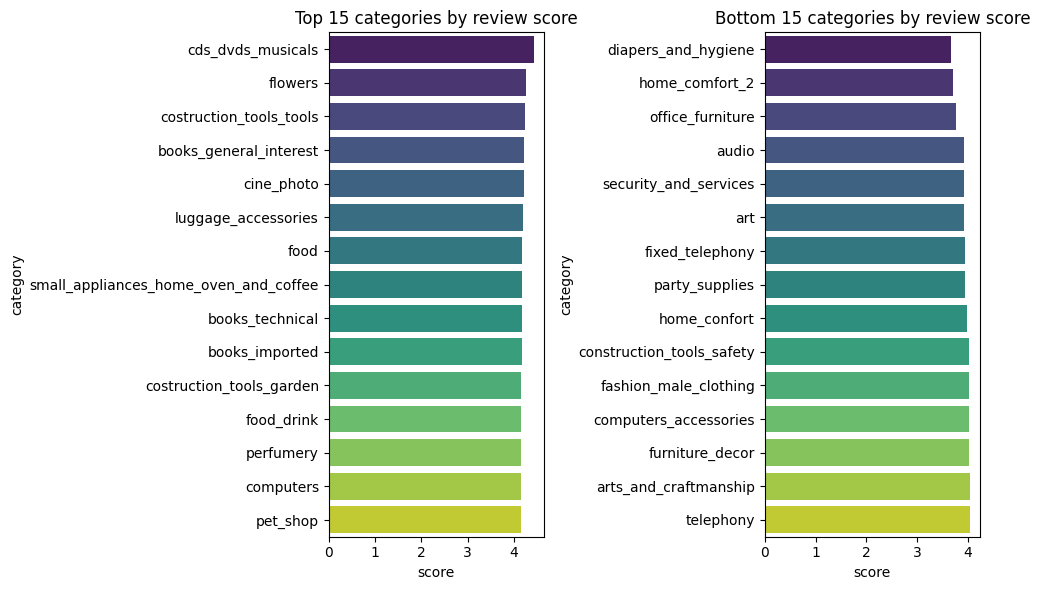

In [40]:
category_score = product_rating.groupby("category").apply(
    lambda g: np.average(g["shrunk_score"], weights=g["n_reviews"])
)

category_score = pd.DataFrame(
    {"category": category_score.index, "score": category_score.values}
)
_, axes = plt.subplots(1, 2, figsize=(10, 6))
for is_ascending, ax in zip([False, True], axes.ravel()):
    sns.barplot(
        data=category_score.sort_values(by="score", ascending=is_ascending).iloc[
            :15, :
        ],
        x="score",
        y="category",
        ax=ax,
        palette="viridis",
    )
    title = (
        "Bottom 15 categories by review score"
        if is_ascending
        else "Top 15 categories by review score"
    )
    ax.set_title(title)
plt.tight_layout()
plt.show()

### Reviews - Mixed Effect Model

To quantify the effects on review scores provided by each product we can still use a regression model, but this time we'll take advantage of a mixed-effects model.</br>
A mixed-effects model is often used when there's data with both fixed and random effects: fixed effects are due to predictable factors which explain the trend, while random effects are unpredictable factors that explain variability between groups.</br>
In our case the predictable effects consists of the logistics and economics (delay, delivery time, price etc.) since we expect these have a consistent influcence over customer satisfaction across the different groups, i.e. the actual products whose variability is "random" (we can't know or reasonably estimate a priori which products are rated higher than others and by how much); in other words, we assume a linear law existing for the fixed effect and the residual on their predictions will define the products contribution to the review score.

In [23]:
model_mem = smf.mixedlm(
    "score ~ delay + log_delivery_time + log_price + log_freight_value + C(state)",
    data=order_rating_1p,
    groups=order_rating_1p["product"],
)

res = model_mem.fit()

res.summary()

The resulting random effects estimation let us associate to each product id the product impact on review rating:

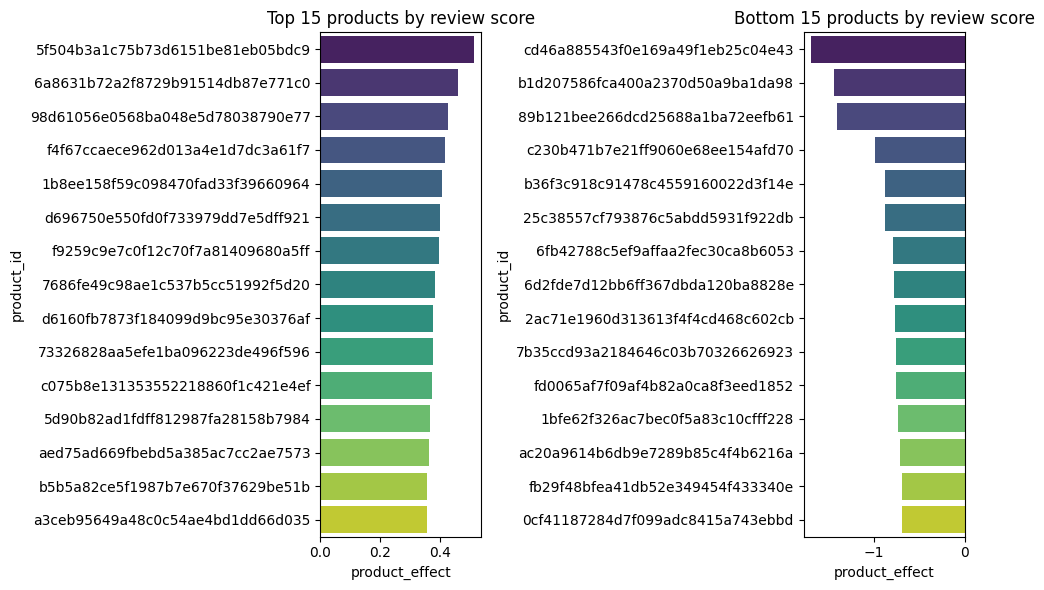

In [36]:
product_effects = res.random_effects

product_effects = (
    pd.DataFrame.from_dict(product_effects, orient="index")
    .reset_index()
    .rename(columns={"index": "product_id", "Group": "product_effect"})
)


_, axes = plt.subplots(1, 2, figsize=(10, 6))
for is_ascending, ax in zip([False, True], axes.ravel()):
    sns.barplot(
        data=product_effects.sort_values(
            by="product_effect", ascending=is_ascending
        ).iloc[:15, :],
        x="product_effect",
        y="product_id",
        ax=ax,
        palette="viridis",
    )
    title = (
        "Bottom 15 products by review score"
        if is_ascending
        else "Top 15 products by review score"
    )
    ax.set_title(title)
plt.tight_layout()
plt.show()

Interestingly, negative impacts on rating have a stronger magnitude than positive ones, as much as surpassing a full point subtracteby the score. 

## Customer Behaviour

In this section of the analysis we aim to study the behaviour of customer; there are many tools available, however it's worth pointing out the particular nature of the Olist market: the olist service is indeed not a subscription business where customer retention is a major focus, but a marketplace where customer can make one single purchase and are not incentivize to return.</br>
This is apparent by the order count distribution for customers:

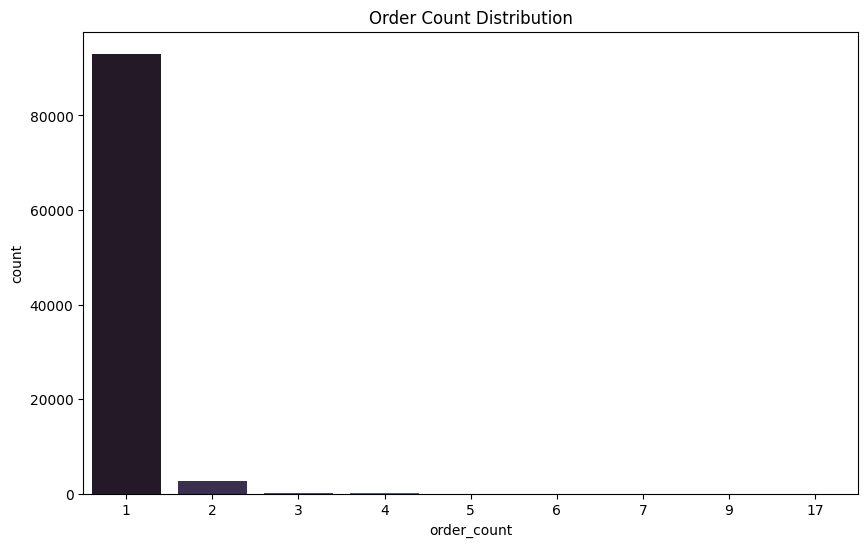

In [8]:
qry = f"""
SELECT 
    customer_unique_id,
    COUNT(DISTINCT order_id) AS order_count
FROM `{PROJECT_ID}.{CORE_DATASET_ID}.fact_orders`
GROUP BY customer_unique_id
"""

df_order_count = run_query(query=qry, project_id=PROJECT_ID)

plt.figure(figsize=(10, 6))
sns.countplot(data=df_order_count, x="order_count", palette="mako")
plt.title("Order Count Distribution")
plt.show()

In [10]:
print(
    "Percentage of customers who placed only one order: ",
    round(
        100 * (df_order_count["order_count"] == 1).sum() / df_order_count.shape[0], 2
    ),
    " %",
)

Percentage of customers who placed only one order:  96.88  %


The vast majority of customers as just placed one order! Behaviour analysis is then included mostly for completion, but it's considered know the fact that customer retention is structurally low.

### End-of-period customer inactivity rate

The end of period customer inactivity rate (EPCIR) is the fraction of customer who made at least one order, but have not made any purchases within a defined time-window before a specific cutoff date.

To compute the EPCIR we first find out the most recent purchase for each customer: we consider a customer inactive when they haven't made a purchase for more than 3 months from the "current date", since the dataset does not have dates beyond Octobre 2018 we'll use its most recent date as the current one, i.e. the cutoff date; in other words if the difference between the cutoff date and a customer most recent purchase is less than 90 days that customer is considered active, otherwise they're inactive.

In [11]:
"""CUSTOMER_enriched

WITH cutoff_date AS (
    SELECT
        MAX(o.purchase_ts) AS cutoff_date
    FROM `{{ PROJECT_ID }}.{{ CORE_DATASET_ID }}.fact_orders` o
)
SELECT
    c.customer_uid AS customer_unique_id,

    -- Dates
    MIN(o.purchase_ts) AS first_purchase_date,
    MAX(o.purchase_ts) AS last_purchase_date,

    -- Recency
    DATE_DIFF(cod.cutoff_date, MAX(o.purchase_ts), DAY) AS recency_days,

    -- Volume
    COUNT(DISTINCT o.order_id) AS frequency,
    COUNT(o.order_id) AS total_items,
    SUM(o.total_order_value) AS monetary_value,
    CASE
       WHEN DATE_DIFF(cod.cutoff_date, MAX(o.purchase_ts), DAY) > 90
       THEN TRUE ELSE FALSE
    END AS has_churned
FROM `{{ PROJECT_ID }}.{{ CORE_DATASET_ID }}.fact_orders` o
JOIN `{{ PROJECT_ID }}.{{ RAW_DATASET_ID }}.customers` c ON o.customer_id = c.customer_id
CROSS JOIN cutoff_date cod
GROUP BY customer_unique_id, cod.cutoff_date;
"""

qry = f"""
SELECT 
    customer_unique_id,
    is_inactive
FROM `{PROJECT_ID}.{ANALYTICS_DATASET_ID}.customer_enriched`
"""

df_EPCIR = run_query(query=qry, project_id=PROJECT_ID)
df_EPCIR.head()

,customer_unique_id,has_churned
0,7b9d52d22310baecad0f9df64872208d,True
1,6a068ccd3a149b5c8ceb4e04c83feb8a,True
2,009b0127b727ab0ba422f6d9604487c7,True
3,281096eb031de8c318bba51915fdd16a,True
4,0eb1ee9dba87f5b36b4613a65074337c,True


The churn rate is then the proportion of customer churned:

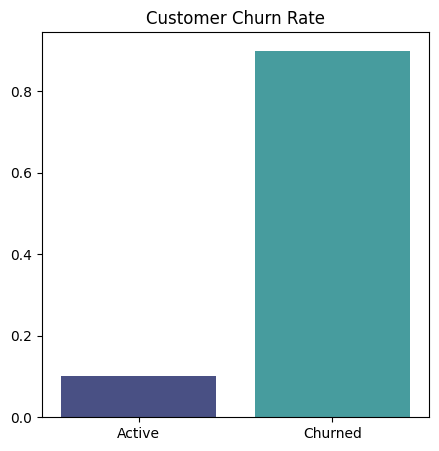

In [12]:
epcr = df_EPCIR["is_inactive"].mean()

plt.figure(figsize=(5, 5))
sns.barplot(x=["Active", "Inactive"], y=[1 - epcr, epcr], palette="mako")
plt.title("Customer Activity Status")
plt.show()

There is a 90.2% inactivity rate, in agreement with the previous considerations.

## Cohort Churn Analysis

For completion we make a quick check on cohort churn, i.e. the proportion of customer from the same acquisition period who stop purchasing for a fixed time-window under acquisition: in this way the time is relative to the first purchase and avoid the end-of-dataset bias of the EPCIR.</br>
We consider our cohort as the month of the first purchase and a full year as churn window:

In [11]:
qry = f"""
SELECT
    *
FROM `{PROJECT_ID}.{ANALYTICS_DATASET_ID}.customer_cohort`
"""

df_cohort = run_query(query=qry, project_id=PROJECT_ID)
df_cohort

,cohort_month,cohort_size,churned,churn_rate
0,2016-09-01 00:00:00+00:00,4,4,1.000000
1,2016-10-01 00:00:00+00:00,321,315,0.981308
2,2016-12-01 00:00:00+00:00,1,0,0.000000
3,2017-01-01 00:00:00+00:00,764,716,0.937173
4,2017-02-01 00:00:00+00:00,1752,1690,0.964612
5,2017-03-01 00:00:00+00:00,2636,2523,0.957132
6,2017-04-01 00:00:00+00:00,2352,2253,0.957908
7,2017-05-01 00:00:00+00:00,3596,3414,0.949388
8,2017-06-01 00:00:00+00:00,3139,2977,0.948391
9,2017-07-01 00:00:00+00:00,3894,3716,0.954289


As expected the churn is still extremely high (between 94 and 100%), we reiterate that in this case these values are not indicative of poor performance, but they rather defines a marketplace with a lot of durable goods and a long repurchase cycle.